# Bilingual document translation

In this example we show an application of SONAR as a means of aligning translated documents for study or language exploration.
We present the novel _The Metamorphosis_ by Franz Kafka in its English version, alongside the translation to German and Spanish.

In [9]:
%pip install --quiet sonar-space scikit-learn fastdtw pandas matplotlib seaborn sentence-splitter


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from fastdtw import fastdtw
from scipy.spatial.distance import cosine
from sentence_splitter import SentenceSplitter
from sklearn.metrics.pairwise import cosine_similarity

from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
from sonar.models.sonar_text import (
    load_sonar_text_encoder_model,
    load_sonar_tokenizer,
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
eng_splitter = SentenceSplitter(language="en")
spa_splitter = SentenceSplitter(language="es")
deu_splitter = SentenceSplitter(language="de")

eng_text = ""
spa_text = ""
deu_text = ""

with open("./data/metamor_eng.txt", "r") as file:
    eng_text = file.read()
with open("./data/metamor_spa.txt", "r") as file:
    spa_text = file.read()
with open("./data/metamor_deu.txt", "r") as file:
    deu_text = file.read()

eng_sentences = eng_splitter.split(text=eng_text)
spa_sentences = spa_splitter.split(text=spa_text)
deu_sentences = deu_splitter.split(text=deu_text)

In [4]:
text_encoder_model = load_sonar_text_encoder_model(
    "text_sonar_basic_encoder", device=device
).eval()
text_tokenizer = load_sonar_tokenizer("text_sonar_basic_encoder")

text_embedding_pipeline = TextToEmbeddingModelPipeline(
    text_encoder_model, text_tokenizer
)

Using the cached checkpoint of text_sonar_basic_encoder. Set `force` to `True` to download again.
Using the cached tokenizer of text_sonar_basic_encoder. Set `force` to `True` to download again.


## Similarity of sentences between texts

We may compute the matrix cosine similarity of each of the sentences in the novel extracts, with each of the sentences present in the translations.

In [5]:
eng_embeddings = text_embedding_pipeline.predict(eng_sentences, source_lang="eng_Latn")
spa_embeddings = text_embedding_pipeline.predict(spa_sentences, source_lang="spa_Latn")
deu_embeddings = text_embedding_pipeline.predict(deu_sentences, source_lang="deu_Latn")

eng_spa_cos_sim = cosine_similarity(eng_embeddings, spa_embeddings)
eng_deu_cos_sim = cosine_similarity(eng_embeddings, deu_embeddings)
spa_deu_cos_sim = cosine_similarity(spa_embeddings, deu_embeddings)

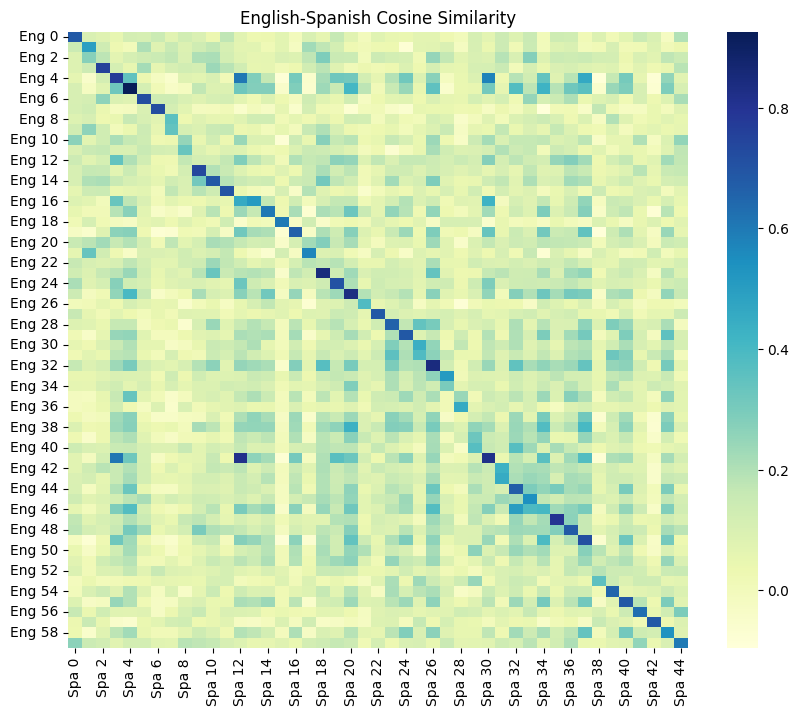

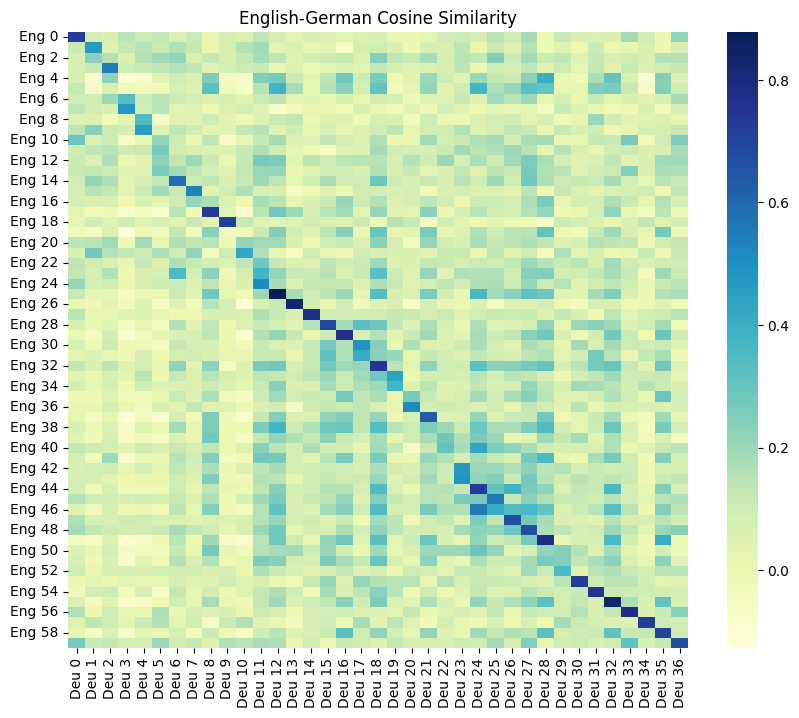

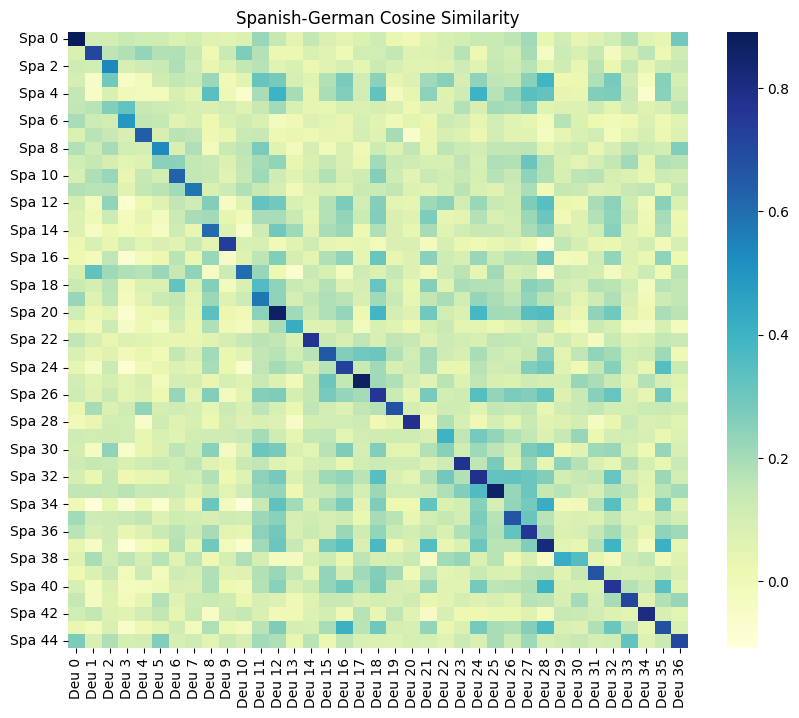

In [6]:
eng_spa_df = pd.DataFrame(
    eng_spa_cos_sim,
    index=[f"Eng {i}" for i in range(len(eng_sentences))],
    columns=[f"Spa {i}" for i in range(len(spa_sentences))],
)

eng_deu_df = pd.DataFrame(
    eng_deu_cos_sim,
    index=[f"Eng {i}" for i in range(len(eng_sentences))],
    columns=[f"Deu {i}" for i in range(len(deu_sentences))],
)

spa_deu_df = pd.DataFrame(
    spa_deu_cos_sim,
    index=[f"Spa {i}" for i in range(len(spa_sentences))],
    columns=[f"Deu {i}" for i in range(len(deu_sentences))],
)


def plot_heatmap(similarity_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=False, cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.show()


plot_heatmap(eng_spa_df, "English-Spanish Cosine Similarity")
plot_heatmap(eng_deu_df, "English-German Cosine Similarity")
plot_heatmap(spa_deu_df, "Spanish-German Cosine Similarity")

## Finding aligned sentence pairs

We may find which of the sentences correspond to which in the translation by determining the cosine distance and considering equivalent in meaning those sentences that are the closest together in the embedding space.

`eng_spa_alignment` contains the actual alignment (or mapping) between the indices of (English and Spanish). The 'cosine' distance is used to measure how similar or dissimilar the embeddings are at each point.

`eng_spa_distance` is the total minimal distance between the two sequences of embeddings the two sequences (English and Spanish embeddings), i.e., which English sentence aligns with which Spanish sentence based on the dynamic time warping (DTW) algorithm.


Sentence Pairs Above Threshold 0.7 (English -> Spanish):
English Sentence 3: His numerous legs, pitifully thin in comparison to the rest of his circumference, flickered helplessly before his eyes. <-> Spanish Sentence 2: Sus muchas patas, ridículamente pequeñas en comparación con el resto de su tamaño, le vibraban desamparadas ante los ojos. (Cosine Similarity: 0.76)
English Sentence 4: "What's happened to me," he thought. <-> Spanish Sentence 3: «¿Qué me ha ocurrido?», pensó. (Cosine Similarity: 0.77)
English Sentence 5: It was no dream. <-> Spanish Sentence 4: No era un sueño. (Cosine Similarity: 0.93)
English Sentence 6: His room, a proper room for a human being, only somewhat too small, lay quietly between the four well-known walls. <-> Spanish Sentence 5: Su habitación, una auténtica habitación humana, si bien algo pequeña, permanecía tranquila entre las cuatro paredes harto conocidas. (Cosine Similarity: 0.72)
English Sentence 7: Above the table, on which an unpacked collection o

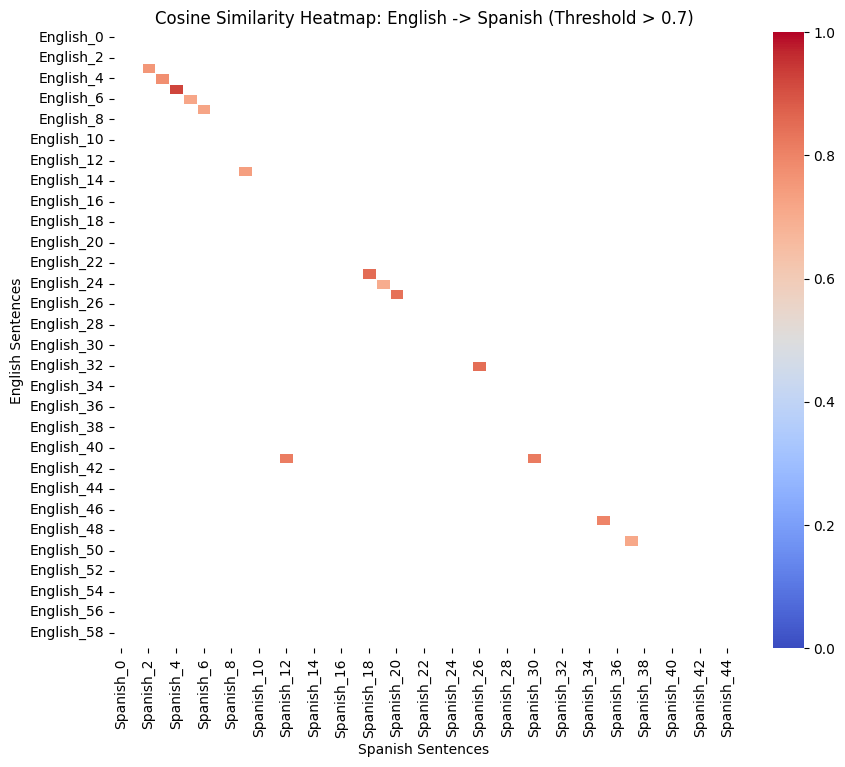

Sentence Pairs Above Threshold 0.7 (English -> German):
English Sentence 0: One morning, as Gregor Samsa was waking up from anxious dreams, he discovered that in bed he had been changed into a monstrous verminous bug. <-> German Sentence 0: Als Gregor Samsa eines Morgens aus unruhigen Träumen erwachte, fand er sich in seinem Bett zu einem ungeheueren Ungeziefer verwandelt. (Cosine Similarity: 0.73)
English Sentence 17: Day in, day out on the road. <-> German Sentence 8: Tag aus, Tag ein auf der Reise. (Cosine Similarity: 0.73)
English Sentence 18: The stresses of trade are much greater than the work going on at head office, and, in addition to that, I have to deal with the problems of traveling, the worries about train connections, irregular bad food, temporary and constantly changing human relationships which never come from the heart. <-> German Sentence 9: Die geschäftlichen Aufregungen sind viel größer, als im eigentlichen Geschäft zuhause, und außerdem ist mir noch diese Plage des

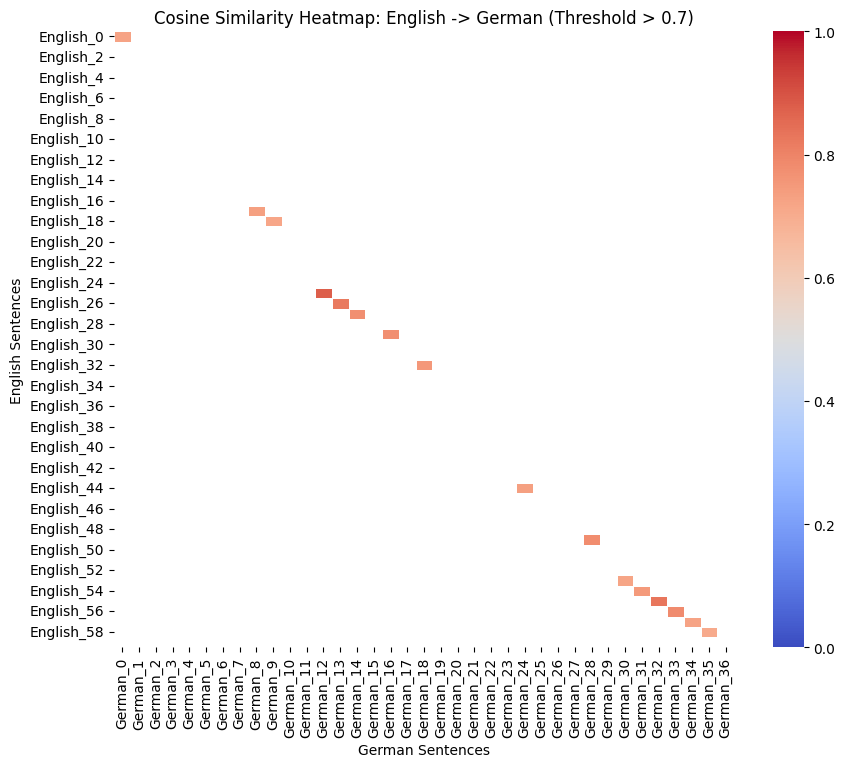

Sentence Pairs Above Threshold 0.7 (Spanish -> German):
Spanish Sentence 0: Cuando Gregorio Samsa se despertó una mañana después de un sueño intranquilo, se encontró sobre su cama convertido en un monstruoso insecto. <-> German Sentence 0: Als Gregor Samsa eines Morgens aus unruhigen Träumen erwachte, fand er sich in seinem Bett zu einem ungeheueren Ungeziefer verwandelt. (Cosine Similarity: 0.89)
Spanish Sentence 1: Estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza, veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo. <-> German Sentence 1: Er lag auf seinem panzerartig harten Rücken und sah, wenn er den Kopf ein wenig hob, seinen gewölbten, braunen, von bogenförmigen Versteifungen geteilten Bauch, auf dessen Höhe sich die Bettdecke, zum gänzlichen Niedergleiten bereit, kaum noch erhalten konnte. (Cosine Similarity: 0.71

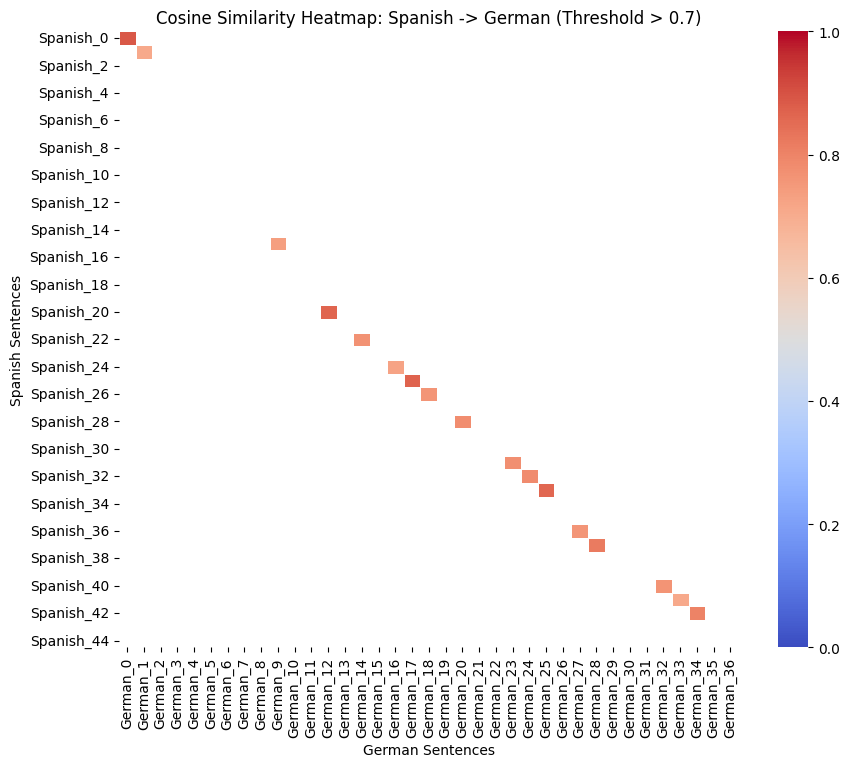

In [7]:
def create_cosine_similarity_heatmap(
    cos_sim_matrix, sent1_list, sent2_list, lang1_name, lang2_name, threshold=0.6
):
    df = pd.DataFrame(
        cos_sim_matrix,
        index=[f"{lang1_name}_{i}" for i in range(len(sent1_list))],
        columns=[f"{lang2_name}_{i}" for i in range(len(sent2_list))],
    )

    mask = df < threshold

    print(f"Sentence Pairs Above Threshold {threshold} ({lang1_name} -> {lang2_name}):")
    for i in range(len(sent1_list)):
        for j in range(len(sent2_list)):
            if df.iat[i, j] >= threshold:
                print(
                    f"{lang1_name} Sentence {i}: {sent1_list[i]} <-> {lang2_name} Sentence {j}: {sent2_list[j]} (Cosine Similarity: {df.iat[i, j]:.2f})"
                )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df,
        mask=mask,
        annot=False,
        cmap="coolwarm",
        cbar=True,
        linewidths=0.5,
        vmin=0,
        vmax=1,
    )
    plt.title(
        f"Cosine Similarity Heatmap: {lang1_name} -> {lang2_name} (Threshold > {threshold})"
    )
    plt.xlabel(f"{lang2_name} Sentences")
    plt.ylabel(f"{lang1_name} Sentences")
    plt.show()


create_cosine_similarity_heatmap(
    eng_spa_cos_sim, eng_sentences, spa_sentences, "English", "Spanish", threshold=0.7
)
create_cosine_similarity_heatmap(
    eng_deu_cos_sim, eng_sentences, deu_sentences, "English", "German", threshold=0.7
)
create_cosine_similarity_heatmap(
    spa_deu_cos_sim, spa_sentences, deu_sentences, "Spanish", "German", threshold=0.7
)

We may encounter special cases where the _translation_ or match between sentences in the embedding space is not 1-to-1. In such instances, a single sentence may exhibit "good enough" similarity with multiple sentences in the other language. Consider the following example:

```
English Sentence 41: "Good God," he thought. <-> Spanish Sentence 12: «Dios mío!», pensó. (Cosine Similarity: 0.82)  
English Sentence 41: "Good God," he thought. <-> Spanish Sentence 30: «¡Dios del cielo!», pensó. (Cosine Similarity: 0.82)  
```

This illustrates that the embedding space captures the implied meaning of sentences rather than relying solely on direct word-for-word translations.


## Creating a Bilingual Book to Read

In this example notebook, one of the applications of the alignment is to create a **bilingual notebook**. This book provides a side-by-side comparison of sentences from different languages. The comparison is made possible by calculating the optimal path through which to traverse the embedding space, considering the cosine similarity at each point. To achieve this efficiently, one can utilize the **FastDTW** algorithm. Note that for this example we are only reconstructing a side-by-side view of the books from what the source of the books provides, but may also be used on texts that where not aligned before.

#### FastDTW

**FastDTW** (Fast Dynamic Time Warping) is an optimized version of Dynamic Time Warping (DTW), a distance measure used to align two sequences of data that may vary in time or length. DTW identifies the optimal alignment by minimizing the distance between the sequences, typically for time series data. It allows for stretching or compressing parts of the sequences to achieve a better match.

A key characteristic of DTW is that it ensures **monotonic alignment**, meaning the sequence of aligned points progresses consistently without reversing. This property is crucial for aligning bilingual texts, where each sentence or phrase in one language should correspond in order with the sentences in another language, preserving the logical sequence.

**Note:** The current alignment implementation does not maintain monotonicity; for example, it may incorrectly match **English Sentence 41 with Spanish Sentence 12**, which disrupts the logical order of the sentences.

FastDTW enhances the speed of computation while approximating the results of traditional DTW, making it more efficient for larger datasets or longer sequences.

For more information on **FastDTW**, see [this](https://cs.fit.edu/~pkc/papers/tdm04.pdf).


In [14]:
def dtw_align(eng_embeddings, spa_embeddings):
    alignments = []

    distance, path = fastdtw(
        eng_embeddings.numpy(), spa_embeddings.numpy(), dist=cosine
    )
    alignments.append(path)

    return alignments


eng_spa_alignments = dtw_align(eng_embeddings, spa_embeddings)


eng_spa_alignments = dtw_align(eng_embeddings, spa_embeddings)

alignment_table = []

for eng_idx, spa_idx in eng_spa_alignments[0]:
    eng_sentence = eng_sentences[eng_idx] if eng_idx < len(eng_sentences) else ""
    spa_sentence = spa_sentences[spa_idx] if spa_idx < len(spa_sentences) else ""

    alignment_table.append((eng_sentence, spa_sentence))

bilingual_df = pd.DataFrame(
    alignment_table, columns=["English Sentence", "Spanish Sentence"]
)
pd.set_option("display.max_colwidth", None)

html_table = bilingual_df.to_html(index=False)
with open("bilingual_book.html", "w") as f:
    f.write(html_table)

from IPython.display import HTML, display

display(HTML(bilingual_df.to_html(index=False)))

English Sentence,Spanish Sentence
"One morning, as Gregor Samsa was waking up from anxious dreams, he discovered that in bed he had been changed into a monstrous verminous bug.","Cuando Gregorio Samsa se despertó una mañana después de un sueño intranquilo, se encontró sobre su cama convertido en un monstruoso insecto."
"He lay on his armour-hard back and saw, as he lifted his head up a little, his brown, arched abdomen divided up into rigid bow-like sections.","Estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza, veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo."
"From this height the blanket, just about ready to slide off completely, could hardly stay in place.","Estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza, veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo."
"His numerous legs, pitifully thin in comparison to the rest of his circumference, flickered helplessly before his eyes.","Sus muchas patas, ridículamente pequeñas en comparación con el resto de su tamaño, le vibraban desamparadas ante los ojos."
"""What's happened to me,"" he thought.","«¿Qué me ha ocurrido?», pensó."
It was no dream.,No era un sueño.
"His room, a proper room for a human being, only somewhat too small, lay quietly between the four well-known walls.","Su habitación, una auténtica habitación humana, si bien algo pequeña, permanecía tranquila entre las cuatro paredes harto conocidas."
"Above the table, on which an unpacked collection of sample cloth goods was spread out (Samsa was a traveling salesman) hung the picture which he had cut out of an illustrated magazine a little while ago and set in a pretty gilt frame.","Por encima de la mesa, sobre la que se encontraba extendido un muestrario de paños desempaquetados – Samsa era viajante de comercio –, estaba colgado aquel cuadro, que hacía poco había recortado de una revista y había colocado en un bonito marco dorado."
It was a picture of a woman with a fur hat and a fur boa.,"Representaba a una dama ataviada con un sombrero y una boa” de piel, que estaba allí, sentada muy erguida y levantaba hacia el observador un pesado manguito de piel, en el cual había desaparecido su antebrazo."
"She sat erect there, lifting up in the direction of the viewer a solid fur muff into which her entire forearm disappeared.","Representaba a una dama ataviada con un sombrero y una boa” de piel, que estaba allí, sentada muy erguida y levantaba hacia el observador un pesado manguito de piel, en el cual había desaparecido su antebrazo."


# Acknowledgements

We use texts from [Bilinguis.com](http://bilinguis.com), which has free books with their translations to different languages, along with some audio books as well.